In [1]:
# Imports
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from collections import deque
import pygame
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# DQN model which takes in the state as an input and outputs predicted q values for every possible action
class DQN(torch.nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        # Add your architecture parameters here
        # You can use nn.Functional
        # Remember that the input is of size batch_size x state_space
        # and the output is of size batch_size x action_space (ulta ho sakta hai dekh lo)
        # TODO: Add code here
        self.state_space=state_space
        self.action_space=action_space
        self.sequential_net=nn.Sequential(nn.Linear(self.state_space,128),
                             nn.ReLU(),
                             nn.Linear(128,128),
                             nn.ReLU(),
                             nn.Linear(128,self.action_space))
    def forward(self, input):
        # TODO: Complete based on your implementation
        output=self.sequential_net(input)
        return output


In [4]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


In [5]:
# TODO: Implement training logic for CartPole environment here
# Remember to use the ExperienceBuffer and a target network
# Details can be found in the book sent in the group
def train_model(model,loss_fn,optimizer,episodes=600,epsilon=1,gamma=0.99,sync_batch_freq=100,train_batch_size=64,replay_buffer_size=10000):

  env = gym.make("CartPole-v1")
  rewards_list=[]
  losses=[]
  obs_dim = env.observation_space.shape[0]
  n_actions = env.action_space.n

  np.random.seed(42)
  action_selection_array=np.arange(n_actions)

  target_model=DQN(obs_dim,n_actions).to(device)
  target_model.load_state_dict(model.state_dict())
  model.train()
  target_model.eval()

  Buffer=ExperienceBuffer(replay_buffer_size)
  iteration=0
  for episode in range(episodes):

    total_reward=0
    done=False
    obs,_=env.reset()
    mov=0

    while not done:

      iteration+=1
      mov+=1
      state_i = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)

      with torch.no_grad():
        q_values = model(state_i)

      if np.random.rand()<epsilon:
        action = np.random.choice(action_selection_array)
      else:
        action = torch.argmax(q_values).item()

      obs,reward,done,truncated,_ = env.step(action)

      if truncated:
        done=True
      total_reward+=reward
      state_f = torch.tensor(obs, dtype=torch.float32).to(device)
      Buffer.push(state_i,action,reward,state_f,done)

      if(len(Buffer)>train_batch_size):
        states, actions, rewards, next_states, dones = Buffer.sample(train_batch_size)
        states=torch.stack(states).to(device)
        actions=torch.tensor(actions).to(device)
        rewards=torch.tensor(rewards).to(device)
        next_states=torch.stack(next_states).to(device)
        dones=torch.Tensor(dones).to(device)

        with torch.no_grad():
          A=torch.max(target_model(next_states),dim=1,keepdim=False).values
          update=rewards+gamma*(1-dones)*(A)

        q_values_predicted=model(states)
        q_values_predicted=q_values_predicted.squeeze(1)
        q_values_to_change=q_values_predicted.gather(1,actions.unsqueeze(1)).squeeze(1)
        loss=loss_fn(q_values_to_change,update)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      if(iteration%sync_batch_freq==0):
        target_model.load_state_dict(model.state_dict())
        target_model.eval()

    if epsilon>0.1:
      epsilon*=0.995

    rewards_list.append(total_reward)

    if episode%50==0:
      print(f"Episode {episode} - Average Reward : {sum(rewards_list[-50:])/50}")

      #To avoid overfitting
      if sum(rewards_list[-50:])/50 >=450:
        break;

  env.close()
  return rewards_list,losses

In [6]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
env.close()
model=DQN(obs_dim,n_actions).to(device)
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
rewards,losses=train_model(model,loss_fn,optimizer)

Episode 0 - Average Reward : 0.38
Episode 50 - Average Reward : 24.3
Episode 100 - Average Reward : 54.84
Episode 150 - Average Reward : 108.36
Episode 200 - Average Reward : 202.98
Episode 250 - Average Reward : 316.36
Episode 300 - Average Reward : 411.58
Episode 350 - Average Reward : 479.12


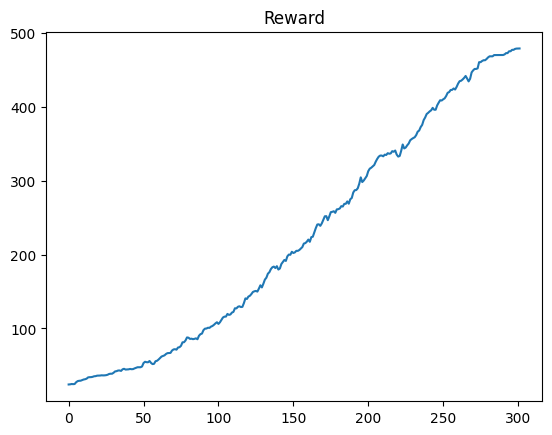

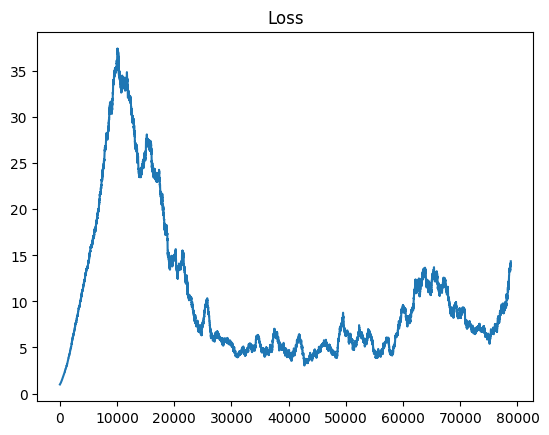

In [7]:
plt.plot(np.convolve(rewards,np.ones((50,))*0.02,mode='valid'))
plt.title("Reward")
plt.show()
plt.plot(np.convolve(losses,np.ones((1000,))*0.001,mode='valid'))
plt.title("Loss")
plt.show()

In [8]:
from os import truncate
def evaluate_cartpole_model(model, episodes=10, render=True):
    env = gym.make("CartPole-v1", render_mode="human" if render else None)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    model.eval()

    rewards = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = model(state)
                action = torch.argmax(q_values, dim=1).item()
            obs, reward, done, truncated, _ = env.step(action)
            if truncated:
              done=True
            total_reward += reward
            if render:
                env.render()
        rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward}")

    env.close()
    avg_reward = sum(rewards) / episodes
    print(f"Average reward over {episodes} episodes: {avg_reward}")

In [9]:
# TODO: Run evaluation for cartpole here
evaluate_cartpole_model(model,render=False)

Episode 1: Reward = 500.0
Episode 2: Reward = 500.0
Episode 3: Reward = 500.0
Episode 4: Reward = 500.0
Episode 5: Reward = 500.0
Episode 6: Reward = 500.0
Episode 7: Reward = 500.0
Episode 8: Reward = 500.0
Episode 9: Reward = 500.0
Episode 10: Reward = 500.0
Average reward over 10 episodes: 500.0


In [10]:
class ChaseEscapeEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, render_mode=None):
        super().__init__()

        self.dt = 0.1
        self.max_speed = 0.4
        self.agent_radius = 0.05
        self.target_radius = 0.05
        self.chaser_radius = 0.07
        self.chaser_speed = 0.03

        self.action_space = gym.spaces.MultiDiscrete([3, 3])  # actions in {0,1,2} map to [-1,0,1]
        self.observation_space = gym.spaces.Box(
            low=-1,
            high=1,
            shape=(8,),
            dtype=np.float32,
        )

        self.render_mode = render_mode
        self.screen_size = 500
        self.np_random = None

        if render_mode == "human":
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
            self.clock = pygame.time.Clock()

    def sample_pos(self, far_from=None, min_dist=0.5):
        while True:
            pos = self.np_random.uniform(low=-0.8, high=0.8, size=(2,))
            if far_from is None or np.linalg.norm(pos - far_from) >= min_dist:
                return pos

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.agent_pos = self.sample_pos()
        self.agent_vel = np.zeros(2, dtype=np.float32)
        self.target_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.5)
        self.chaser_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.7)

        return self._get_obs(), {}

    def _get_obs(self):
        # TODO: Decide how to pass the state (don't use pixel values)
        return (*self.agent_pos,*(self.target_pos-self.agent_pos),*(self.chaser_pos-self.agent_pos),*self.agent_vel)

    def _get_info(self):
        return {}

    def step(self, action):
        # TODO: Add reward scheme
        # 1) Try to make the agent stay within bounds
        # 2) The agent shouldn't idle around
        # 3) The agent should go for the reward
        # 4) The agent should avoid the chaser

        reward=0
        accel = (np.array(action) - 1) * 0.1
        self.agent_vel += accel
        self.agent_vel = np.clip(self.agent_vel, -self.max_speed, self.max_speed)
        prev_pos=self.agent_pos
        self.agent_pos += self.agent_vel * self.dt
        Y=self.agent_pos
        self.agent_pos = np.clip(self.agent_pos, -1, 1)

        if np.abs(self.agent_pos)[0]>=0.9 or np.abs(self.agent_pos)[1]>=0.9:
            reward-=0.001
        else :
            reward+=0.001

        if np.abs(self.agent_pos)[0]>=0.90 and np.abs(self.agent_pos)[1]>=0.90:
            reward-=float((np.abs(self.agent_pos)[0]-0.90)*0.1)

        direction = self.agent_pos - self.chaser_pos
        norm = np.linalg.norm(direction)

        if norm > 1e-5:
            self.chaser_pos += self.chaser_speed * direction / norm

        dist_to_target = np.linalg.norm(self.agent_pos - self.target_pos)
        dist_to_chaser = np.linalg.norm(self.agent_pos - self.chaser_pos)
        prev_dist_to_target= np.linalg.norm(self.target_pos-prev_pos)
        prev_dist_to_chaser = np.linalg.norm(self.chaser_pos-prev_pos)
        terminated = False


        if dist_to_target<=1:
            reward+=float((1-dist_to_target)*10)

        if prev_dist_to_chaser>=dist_to_chaser and dist_to_chaser<=0.40:
            reward-=0.05

        reward+=0.05

        if dist_to_target < self.agent_radius + self.target_radius:
            reward+=5
            self.target_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.5)

        if dist_to_chaser < self.agent_radius + self.chaser_radius:
            reward-=1
            terminated = True

        return self._get_obs(), reward, terminated, False, self._get_info()

    def render(self):
        if self.render_mode != "human":
            return

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()

        self.screen.fill((255, 255, 255))

        def to_screen(p):
            x = int((p[0] + 1) / 2 * self.screen_size)
            y = int((1 - (p[1] + 1) / 2) * self.screen_size)
            return x, y

        pygame.draw.circle(self.screen, (0, 255, 0), to_screen(self.target_pos), int(self.target_radius * self.screen_size*0.5))
        pygame.draw.circle(self.screen, (0, 0, 255), to_screen(self.agent_pos), int(self.agent_radius * self.screen_size*0.5))
        pygame.draw.circle(self.screen, (255, 0, 0), to_screen(self.chaser_pos), int(self.chaser_radius * self.screen_size*0.5))

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def close(self):
        if self.render_mode == "human":
            pygame.quit()

In [11]:
class DQN_chaseescape(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_net=nn.Sequential(
                            nn.Linear(8,128),
                            nn.ReLU(),
                            nn.Linear(128,128),
                            nn.ReLU(),
                            nn.Linear(128,64),
                            nn.ReLU(),
                            nn.Linear(64,9),
                            )
    def forward(self, input):
        input=input.view(-1,8)
        return self.sequential_net(input)

In [12]:
def train_ChaseEscapEnv(model,loss_fn,optimizer,episodes=700,epsilon=1,gamma=0.99,sync_batch_freq=100,train_batch_size=64,replay_buffer_size=10000):

  env = ChaseEscapeEnv()
  rewards_list=[]
  number_of_moves_list=[]
  losses=[]
  no_of_food_eaten_list=[]

  np.random.seed(42)
  action_selection_array=np.arange(9)

  target_model=DQN_chaseescape().to(device)
  target_model.load_state_dict(model.state_dict())
  model.train()
  target_model.eval()

  Buffer=ExperienceBuffer(replay_buffer_size)
  iteration=0
  for episode in range(episodes):

    total_reward=0
    done=False
    obs,_=env.reset()
    moves=0
    no_of_food_eaten=0
    while not done:
      moves+=1
      iteration+=1
      state_i = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)

      with torch.no_grad():
        q_values = model(state_i)

      if np.random.rand()<epsilon:
        action = np.random.choice(action_selection_array)
      else:
        action = torch.argmax(q_values).item()

      obs,reward,done,truncated,_ = env.step((action%3,(action//3)%3))

      if reward >= 11:
        no_of_food_eaten+=1
      total_reward+=reward
      state_f = torch.tensor(obs, dtype=torch.float32).to(device)

      Buffer.push(state_i,action,reward,state_f,done)

      if(len(Buffer)>train_batch_size):
        states, actions, rewards, next_states, dones = Buffer.sample(train_batch_size)
        states=torch.stack(states).to(device)
        actions=torch.tensor(actions).to(device)
        rewards=torch.tensor(rewards).to(device)
        next_states=torch.stack(next_states).to(device)
        dones=torch.Tensor(dones).to(device)

        with torch.no_grad():
          A=torch.max(target_model(next_states),dim=1,keepdim=False).values
          update=rewards+gamma*(1-dones)*(A)
        q_values_predicted=model(states)
        q_values_to_change=q_values_predicted.gather(1,actions.unsqueeze(1)).squeeze(1)
        loss=loss_fn(q_values_to_change,update)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      if(iteration%sync_batch_freq==0):
        target_model.load_state_dict(model.state_dict())
        target_model.eval()
      if moves>=500:
          break

    if epsilon>0.1:
      epsilon*=0.995

    rewards_list.append(total_reward)
    number_of_moves_list.append(moves)
    no_of_food_eaten_list.append(no_of_food_eaten)

    if(episode%50==0):
      print(f"Episode {episode} - Average Reward : {sum(rewards_list[-50:])/50:.2f} Average Moves : {sum(number_of_moves_list[-50:])/50} Average Food Eaten : {sum(no_of_food_eaten_list[-50:])/50:.2f}")
    if len(no_of_food_eaten_list) > 50 and sum(no_of_food_eaten_list[-50:])/50 > 0.6:
        print(f"Episode {episode} - Average Reward : {sum(rewards_list[-50:])/50:.2f} Average Moves : {sum(number_of_moves_list[-50:])/50} Average Food Eaten : {sum(no_of_food_eaten_list[-50:])/50:.2f}")
        break
  env.close()
  return rewards_list,losses

In [13]:
model=DQN_chaseescape().to(device)

In [14]:
loss_fn = nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
rewards,losses=train_ChaseEscapEnv(model,loss_fn,optimizer)

Episode 0 - Average Reward : 0.77 Average Moves : 1.16 Average Food Eaten : 0.00
Episode 50 - Average Reward : 78.50 Average Moves : 46.32 Average Food Eaten : 0.04
Episode 100 - Average Reward : 156.17 Average Moves : 49.7 Average Food Eaten : 0.10
Episode 150 - Average Reward : 448.25 Average Moves : 198.72 Average Food Eaten : 0.32
Episode 200 - Average Reward : 490.46 Average Moves : 274.8 Average Food Eaten : 0.30
Episode 250 - Average Reward : 716.87 Average Moves : 351.58 Average Food Eaten : 0.56
Episode 290 - Average Reward : 811.23 Average Moves : 322.46 Average Food Eaten : 0.66


In [15]:
def evaluate_modelChaseEscapeEnv(model, episodes=10, render=True,moves_limit=500):
    env = ChaseEscapeEnv(render_mode="human")
    target_reached_list=[]
    moves_list=[]
    model.eval()
    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        moves=0
        target_reached=0
        while not done:
            moves+=1
            obs+=np.random.rand(len(obs))*0.1 #To Avoid the Agent getting Stuck in Loops
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = model(state)
                action = torch.argmax(q_values, dim=1).item()
            obs, reward, done, _, _ = env.step((action%3,(action//3)%3))
            if reward>=11:
              target_reached+=1
            if render:
                env.render()
            if moves>moves_limit:
              break
        rewards.append(total_reward)
        moves_list.append(moves)
        target_reached_list.append(target_reached)
        print(f"Episode {episode + 1}: No Of Moves = {moves} Target Chased = {target_reached}")
    env.close()
    avg_moves = sum(moves_list)/ episodes
    avg_target = sum(target_reached_list)/episodes
    print(f"Average Number of Moves over {episodes} episodes: {avg_moves:.2f}")
    print(f"Average Number of times Target Chased over {episodes} episodes: {avg_target:.2f}")



In [16]:
evaluate_modelChaseEscapeEnv(model,episodes=50,moves_limit=1500,render=False)

Episode 1: No Of Moves = 28 Target Chased = 0
Episode 2: No Of Moves = 46 Target Chased = 0
Episode 3: No Of Moves = 54 Target Chased = 0
Episode 4: No Of Moves = 12 Target Chased = 0
Episode 5: No Of Moves = 1501 Target Chased = 1
Episode 6: No Of Moves = 62 Target Chased = 0
Episode 7: No Of Moves = 1113 Target Chased = 1
Episode 8: No Of Moves = 1501 Target Chased = 0
Episode 9: No Of Moves = 16 Target Chased = 0
Episode 10: No Of Moves = 477 Target Chased = 3
Episode 11: No Of Moves = 63 Target Chased = 0
Episode 12: No Of Moves = 1501 Target Chased = 0
Episode 13: No Of Moves = 1501 Target Chased = 0
Episode 14: No Of Moves = 236 Target Chased = 1
Episode 15: No Of Moves = 1501 Target Chased = 4
Episode 16: No Of Moves = 353 Target Chased = 5
Episode 17: No Of Moves = 199 Target Chased = 1
Episode 18: No Of Moves = 1501 Target Chased = 0
Episode 19: No Of Moves = 1501 Target Chased = 1
Episode 20: No Of Moves = 279 Target Chased = 1
Episode 21: No Of Moves = 1501 Target Chased = 0

In [16]:
#Snake Game